# ANN Planner for Robotic Arm - Jupyter Notebook Version

This notebook demonstrates the training and inference of a neural network planner for a robotic arm, using image input and predicting both a trajectory (regression) and a binary choice (classification).

Ensure you have the required data and utility functions in your workspace.

In [1]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt

import utils  # Make sure utils.py is available in the same directory

## GLEPlanner Model Definition

In [2]:
from gle_planner import GLEPlanner

## Dataset and DataLoader

In [3]:
from ann_planner import RobotArmDataset

## Data Loading

Set your data directory and load all necessary data using the provided utility functions.

In [4]:
# Define your data directory relative to where you run this notebook
DATA_DIR = './data/'  # Update if your data is elsewhere
print(f"Using data from: {DATA_DIR}")

loaded_data = utils.load_all_predefined_data_and_config(DATA_DIR)
if loaded_data is None:
    print("Failed to load data, please check DATA_DIR and utility functions.")
else:
    FLEXION_TRAJECTORY_DATA = loaded_data['FLEXION_TRAJECTORY_DATA']
    EXTENSION_TRAJECTORY_DATA = loaded_data['EXTENSION_TRAJECTORY_DATA']
    TASK_MAPPING = loaded_data['TASK_MAPPING']
    TRAJECTORY_LEN = loaded_data['TRAJECTORY_LEN']
    INITIAL_ELBOW_ANGLE = loaded_data['INITIAL_ELBOW_ANGLE']

    all_image_data = utils.get_image_paths_and_labels(
        DATA_DIR,
        FLEXION_TRAJECTORY_DATA,
        EXTENSION_TRAJECTORY_DATA,
        TASK_MAPPING,
        INITIAL_ELBOW_ANGLE
    )
    print(f"Loaded {len(all_image_data)} distinct data samples for training.")
    if not all_image_data:
        print("No image data found. Please check DATA_DIR and filename patterns.")

Using data from: ./data/
Loaded 4 distinct data samples for training.


## Image Transform and DataLoader

In [5]:
# Only continue if data loaded successfully
if loaded_data is not None and all_image_data:
    image_transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to a vector
    ])
    train_dataset = RobotArmDataset(all_image_data, transform=image_transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=len(all_image_data),  # Full batch for small dataset
        shuffle=True
    )
else:
    train_dataset = None
    train_loader = None

## Model, Loss Functions, and Optimizer

In [6]:
if loaded_data is not None and all_image_data:
    num_choices = 2
    model = GLEPlanner(tau=1.0, dt=0.01, num_choices=num_choices, trajectory_length=TRAJECTORY_LEN)

    criterion_trajectory = nn.MSELoss()
    criterion_choice = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
else:
    model = None

## Training Loop

**Note:** You may want to reduce `num_epochs` for quick prototyping. Set higher for better results.

In [7]:
if loaded_data is not None and all_image_data:
    num_epochs = 500  # You can reduce this for testing, e.g., num_epochs = 10
    print("\nStarting offline training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, true_trajectory, target_choice_idx) in enumerate(train_loader):
            optimizer.zero_grad()
            target = torch.cat((true_trajectory, torch.nn.functional.one_hot(target_choice_idx, num_classes=num_choices)), dim=1)
            with torch.no_grad():
                for _ in range(10):
                    output = model(images, target, beta=1.0)  # Assuming beta is a hyperparameter for the error computation
                optimizer.step()
            predicted_trajectory = output[:, :TRAJECTORY_LEN]  # First part is the trajectory
            choice_logits = output[:, TRAJECTORY_LEN:]  # Second part is the choice logits
            loss_trajectory = criterion_trajectory(predicted_trajectory, true_trajectory)
            loss_choice = criterion_choice(choice_logits, target_choice_idx)
            total_loss = loss_trajectory + loss_choice
            running_loss += total_loss.item()
        # Print loss less frequently due to high epoch count
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.6f}")
    print("\nTraining finished.")


Starting offline training...
Epoch 1/500, Loss: 3.319352
Epoch 100/500, Loss: 0.843336
Epoch 200/500, Loss: 0.694586
Epoch 300/500, Loss: 0.692775
Epoch 400/500, Loss: 0.692667
Epoch 500/500, Loss: 0.692667

Training finished.


## Save the Trained Model

In [8]:
if model is not None:
    MODEL_SAVE_PATH = 'trained_gle_planner.pth'
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to trained_gle_planner.pth


## Demonstration of Inference

Plot example predictions versus ground truth.


--- Demonstration of Inference ---
Evaluating on training data:

--- Input Image: start_20_red.bmp ---
Initial Angle (Hardcoded): 90°
Target Final Angle (from filename): 20°
Calculated Angle Difference: -70°
True Choice: right
Predicted Choice (Left/Right): right
True Trajectory (first 5 points): [1.570796 1.570796 1.570796 1.570796 1.570796]
Predicted Trajectory (first 5 points): [1.569191  1.567416  1.5678633 1.5691433 1.5684402]


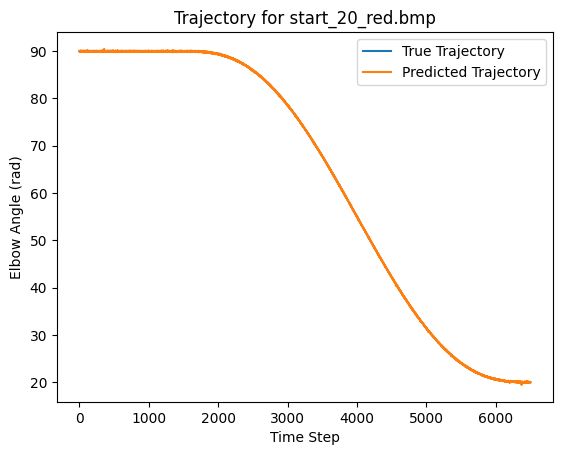


--- Input Image: start_20_blue.bmp ---
Initial Angle (Hardcoded): 90°
Target Final Angle (from filename): 20°
Calculated Angle Difference: -70°
True Choice: right
Predicted Choice (Left/Right): right
True Trajectory (first 5 points): [1.570796 1.570796 1.570796 1.570796 1.570796]
Predicted Trajectory (first 5 points): [1.5704366 1.5697229 1.5704656 1.570497  1.5705866]


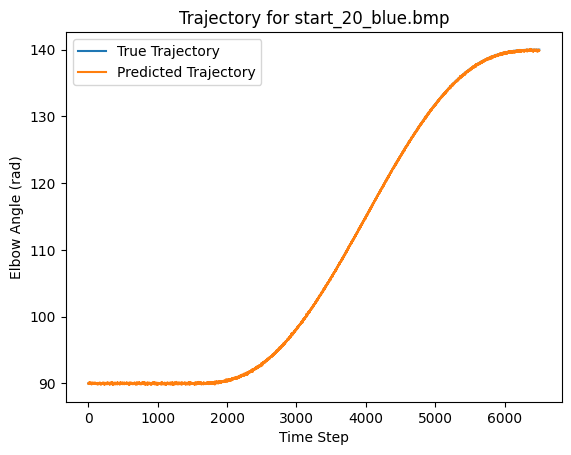


--- Input Image: start_140_blue.bmp ---
Initial Angle (Hardcoded): 90°
Target Final Angle (from filename): 140°
Calculated Angle Difference: 50°
True Choice: left
Predicted Choice (Left/Right): right
True Trajectory (first 5 points): [1.570796 1.570796 1.570796 1.570796 1.570796]
Predicted Trajectory (first 5 points): [1.5700003 1.5684526 1.5683675 1.5687002 1.5685495]


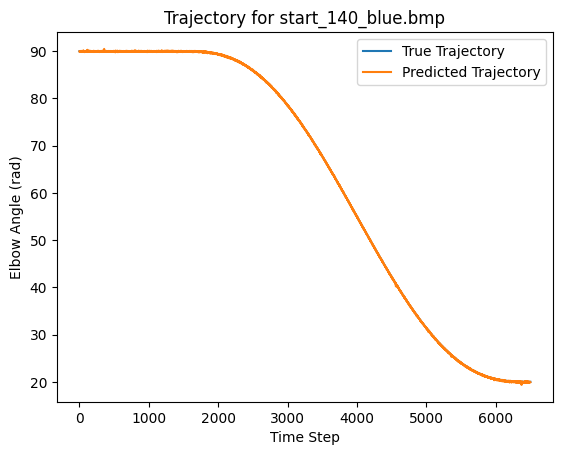


--- Input Image: start_140_red.bmp ---
Initial Angle (Hardcoded): 90°
Target Final Angle (from filename): 140°
Calculated Angle Difference: 50°
True Choice: left
Predicted Choice (Left/Right): left
True Trajectory (first 5 points): [1.570796 1.570796 1.570796 1.570796 1.570796]
Predicted Trajectory (first 5 points): [1.5700862 1.569543  1.5687096 1.5691401 1.5693172]


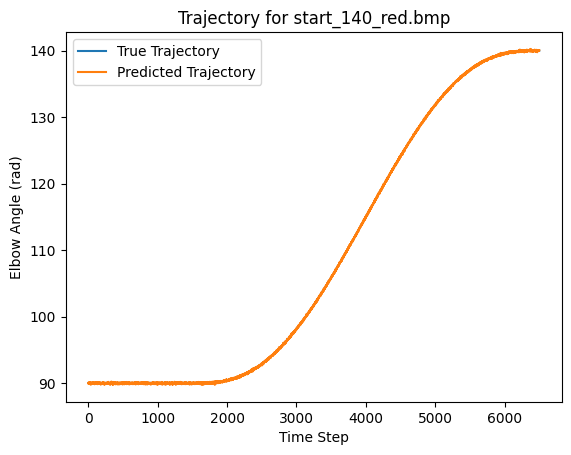

In [9]:
if model is not None:
    from gle_planner import evaluate_model
    evaluate_model(model, train_loader, all_image_data)